Epoch 1/10
  Training accuracy: 0.9509, Training loss: 0.1632
  Validation accuracy: 0.9444, Validation loss: 0.1857
Validation loss improved from inf to 0.1857. Saving model...
INFO:tensorflow:Assets written to: checkpoint_path_tf_only\assets


INFO:tensorflow:Assets written to: checkpoint_path_tf_only\assets


Epoch 2/10
  Training accuracy: 0.9695, Training loss: 0.1038
  Validation accuracy: 0.9635, Validation loss: 0.1302
Validation loss improved from 0.1857 to 0.1302. Saving model...
INFO:tensorflow:Assets written to: checkpoint_path_tf_only\assets


INFO:tensorflow:Assets written to: checkpoint_path_tf_only\assets


Epoch 3/10
  Training accuracy: 0.9771, Training loss: 0.0783
  Validation accuracy: 0.9684, Validation loss: 0.1106
Validation loss improved from 0.1302 to 0.1106. Saving model...
INFO:tensorflow:Assets written to: checkpoint_path_tf_only\assets


INFO:tensorflow:Assets written to: checkpoint_path_tf_only\assets


Epoch 4/10
  Training accuracy: 0.9815, Training loss: 0.0640
  Validation accuracy: 0.9721, Validation loss: 0.1011
Validation loss improved from 0.1106 to 0.1011. Saving model...
INFO:tensorflow:Assets written to: checkpoint_path_tf_only\assets


INFO:tensorflow:Assets written to: checkpoint_path_tf_only\assets


Epoch 5/10
  Training accuracy: 0.9827, Training loss: 0.0580
  Validation accuracy: 0.9713, Validation loss: 0.1038
Epoch 6/10
  Training accuracy: 0.9859, Training loss: 0.0473
  Validation accuracy: 0.9753, Validation loss: 0.0953
Validation loss improved from 0.1011 to 0.0953. Saving model...
INFO:tensorflow:Assets written to: checkpoint_path_tf_only\assets


INFO:tensorflow:Assets written to: checkpoint_path_tf_only\assets


Epoch 7/10
  Training accuracy: 0.9885, Training loss: 0.0402
  Validation accuracy: 0.9764, Validation loss: 0.0924
Validation loss improved from 0.0953 to 0.0924. Saving model...
INFO:tensorflow:Assets written to: checkpoint_path_tf_only\assets


INFO:tensorflow:Assets written to: checkpoint_path_tf_only\assets


Epoch 8/10
  Training accuracy: 0.9894, Training loss: 0.0372
  Validation accuracy: 0.9767, Validation loss: 0.0920
Validation loss improved from 0.0924 to 0.0920. Saving model...
INFO:tensorflow:Assets written to: checkpoint_path_tf_only\assets


INFO:tensorflow:Assets written to: checkpoint_path_tf_only\assets


Epoch 9/10
  Training accuracy: 0.9904, Training loss: 0.0330
  Validation accuracy: 0.9780, Validation loss: 0.0899
Validation loss improved from 0.0920 to 0.0899. Saving model...
INFO:tensorflow:Assets written to: checkpoint_path_tf_only\assets


INFO:tensorflow:Assets written to: checkpoint_path_tf_only\assets


Epoch 10/10
  Training accuracy: 0.9916, Training loss: 0.0288
  Validation accuracy: 0.9782, Validation loss: 0.0902


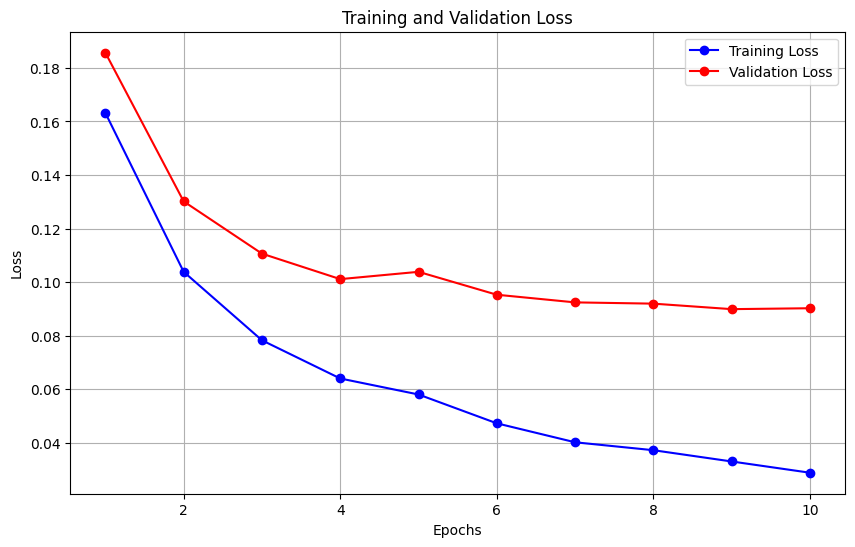

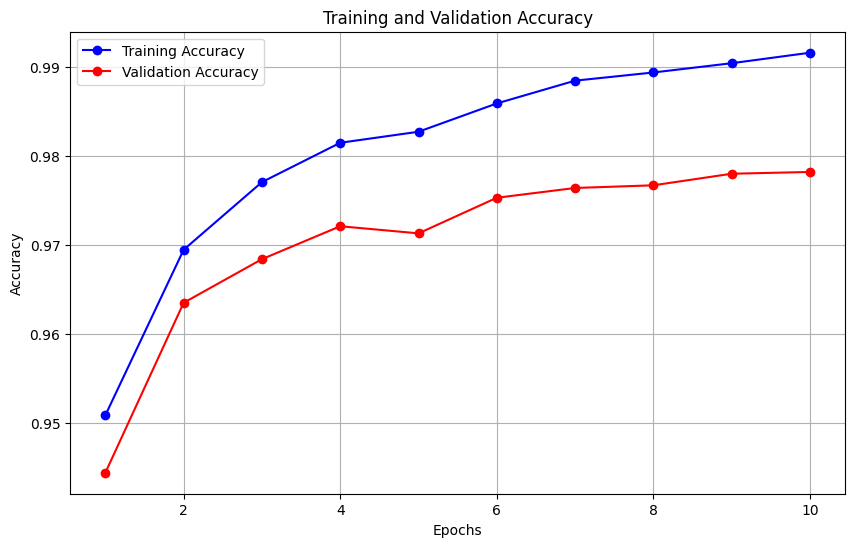

In [5]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# 1. Tải và chuẩn bị dữ liệu
(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

# 2. Xây dựng mô hình với tf.Module
class MNISTModel(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.W1 = tf.Variable(tf.random.normal([784, 512], stddev=0.1), name="W1")
        self.b1 = tf.Variable(tf.zeros([512]), name="b1")
        self.W2 = tf.Variable(tf.random.normal([512, 10], stddev=0.1), name="W2")
        self.b2 = tf.Variable(tf.zeros([10]), name="b2")

    @tf.function
    def __call__(self, inputs, training=False):
        features = tf.matmul(inputs, self.W1) + self.b1
        features = tf.nn.relu(features)
        if training:
            features = tf.nn.dropout(features, rate=0.5)
        outputs = tf.matmul(features, self.W2) + self.b2
        return outputs

# 3. Tự định nghĩa hàm mất mát và optimizer
def sparse_categorical_crossentropy_tf(y_true, logits):
    y_true_int64 = tf.cast(y_true, dtype=tf.int64)
    loss_per_example = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true_int64, logits=logits)
    return tf.reduce_mean(loss_per_example)

class RMSpropOptimizer:
    def __init__(self, learning_rate=0.001, rho=0.9, epsilon=1e-7):
        self.learning_rate = learning_rate
        self.rho = rho
        self.epsilon = epsilon
        self.states = {}

    def apply_gradients(self, grads_and_vars):
        for grad, var in grads_and_vars:
            var_id = id(var)
            if var_id not in self.states:
                self.states[var_id] = tf.Variable(tf.zeros_like(var))
            state_var = self.states[var_id]
            new_state = self.rho * state_var + (1 - self.rho) * tf.square(grad)
            self.states[var_id].assign(new_state)
            var.assign_sub(self.learning_rate * grad / (tf.sqrt(new_state) + self.epsilon))
            
# 4. Hàm tính toán độ chính xác
def accuracy(y_pred_logits, y_true):
    y_pred_softmax = tf.nn.softmax(y_pred_logits)
    correct_predictions = tf.equal(tf.argmax(y_pred_softmax, axis=1), tf.cast(y_true, dtype=tf.int64))
    return tf.reduce_mean(tf.cast(correct_predictions, dtype=tf.float32))

# 5. Huấn luyện mô hình với EarlyStopping và ModelCheckpoint
model = MNISTModel()
loss_fn = sparse_categorical_crossentropy_tf
optimizer = RMSpropOptimizer(learning_rate=0.001)

epochs = 10
batch_size = 128
num_batches = len(train_images) // batch_size

history = {
    'loss': [],
    'val_loss': [],
    'accuracy': [],
    'val_accuracy': []
}

# Biến cho EarlyStopping
patience = 2
best_val_acc = 0.0
epochs_no_improve = 0
early_stop = False

# Biến cho ModelCheckpoint
best_val_loss = float('inf')
checkpoint_path = "checkpoint_path_tf_only"

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    for i in range(num_batches):
        start = i * batch_size
        end = start + batch_size
        x_batch = train_images[start:end]
        y_batch = train_labels[start:end]

        with tf.GradientTape() as tape:
            logits = model(x_batch, training=True)
            current_loss = loss_fn(y_batch, logits)

        gradients = tape.gradient(current_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    logits_train = model(train_images)
    acc_train = accuracy(logits_train, train_labels)
    loss_train = loss_fn(train_labels, logits_train)
    
    logits_val = model(val_images)
    acc_val = accuracy(logits_val, val_labels)
    loss_val = loss_fn(val_labels, logits_val)

    history['loss'].append(loss_train.numpy())
    history['val_loss'].append(loss_val.numpy())
    history['accuracy'].append(acc_train.numpy())
    history['val_accuracy'].append(acc_val.numpy())
    
    print(f"  Training accuracy: {acc_train:.4f}, Training loss: {loss_train:.4f}")
    print(f"  Validation accuracy: {acc_val:.4f}, Validation loss: {loss_val:.4f}")

    # Logic EarlyStopping
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1}. No improvement in validation accuracy for {patience} epochs.")
        early_stop = True

    # Logic ModelCheckpoint
    if loss_val < best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {loss_val:.4f}. Saving model...")
        best_val_loss = loss_val
        # Lưu trạng thái của mô hình
        tf.saved_model.save(model, checkpoint_path)

    if early_stop:
        break

# 6. Vẽ biểu đồ
epochs_range = range(1, len(history['loss']) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, history['loss'], 'bo-', label='Training Loss')
plt.plot(epochs_range, history['val_loss'], 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, history['accuracy'], 'bo-', label='Training Accuracy')
plt.plot(epochs_range, history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()